In [12]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [13]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [55]:
PATH = "../input/diabetic-retinopathy-detection/"
TMP_PATH = "/tmp/tmp"
MODEL_PATH = "/tmp/model/"
sz=224  # default

arch=resnet34
# sz = 64  # Because medical images.
# Not sure anymore about sz=64
bs = 4  # Because we have a very limited sample

In [56]:
print('Make sure cuda is installed:', torch.cuda.is_available())
print('Make sure cudnn is enabled:', torch.backends.cudnn.enabled)

Make sure cuda is installed: True
Make sure cudnn is enabled: True


In [57]:
# Создаем строку рабочей директории
base_image_dir = os.path.join('..','input','diabetic-retinopathy-detection')
# Считаем базу
retina_df = pd.read_csv(os.path.join(base_image_dir, 'trainLabels.csv'))

In [58]:
retina_df.head()

image  level
0   10_left      0
1  10_right      0
2   13_left      0
3  13_right      0
4   15_left      1

In [59]:
# Добавляем колонку PatientID, берем название image и разделяем название 
# по '_', 0 позиция = цифра
retina_df['PatientID'] = retina_df['image'].map(lambda x: x.split('_')[0])
# Создали путь в img
retina_df['path'] = retina_df['image'].map(lambda x: os.path.join( base_image_dir, '{}.jpeg'.format(x)))

In [60]:
retina_df.head(3).T

0  \
image                                                10_left   
level                                                      0   
PatientID                                                 10   
path       ../input/diabetic-retinopathy-detection/10_lef...   

                                                           1  \
image                                               10_right   
level                                                      0   
PatientID                                                 10   
path       ../input/diabetic-retinopathy-detection/10_rig...   

                                                           2  
image                                                13_left  
level                                                      0  
PatientID                                                 13  
path       ../input/diabetic-retinopathy-detection/13_lef...

In [61]:
# Лежат ли данные по заданному пути
retina_df['exists'] = retina_df['path'].map(os.path.exists)

In [62]:
retina_df.head(3).T

0  \
image                                                10_left   
level                                                      0   
PatientID                                                 10   
path       ../input/diabetic-retinopathy-detection/10_lef...   
exists                                                  True   

                                                           1  \
image                                               10_right   
level                                                      0   
PatientID                                                 10   
path       ../input/diabetic-retinopathy-detection/10_rig...   
exists                                                  True   

                                                           2  
image                                                13_left  
level                                                      0  
PatientID                                                 13  
path       ../input/diabetic-retinopathy-detection/13_lef...  
exists                                                  True

In [63]:
# Все ли данные подтвердились
print( retina_df['exists'].sum(), 'images found of', retina_df.shape[0], 'total')

35126 images found of 35126 total


In [64]:
# Сделали колонку с левыми и правыми глазами
retina_df['eye'] = retina_df['image'].map( lambda x: 1 if x.split('_')[-1] == 'left' else 0 )

In [65]:
retina_df.shape

(35126, 6)

In [66]:
retina_df.dropna(inplace = True)

In [67]:
retina_df = retina_df[retina_df['exists']]
retina_df.sample(3)

image  level PatientID  \
28366   35901_left      0     35901   
7720     9708_left      0      9708   
32765  41342_right      3     41342   

                                                    path  exists  eye  
28366  ../input/diabetic-retinopathy-detection/35901_...    True    1  
7720   ../input/diabetic-retinopathy-detection/9708_l...    True    1  
32765  ../input/diabetic-retinopathy-detection/41342_...    True    0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f18d7333c50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f18d35fb208>]], dtype=object)

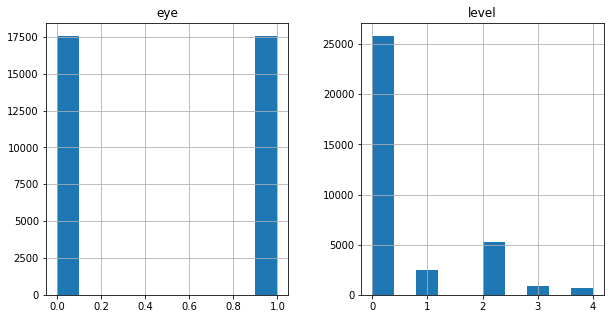

In [68]:
retina_df[['level','eye']].hist(figsize = (10,5))

In [69]:
retina_df.head()

image  level PatientID  \
0   10_left      0        10   
1  10_right      0        10   
2   13_left      0        13   
3  13_right      0        13   
4   15_left      1        15   

                                                path  exists  eye  
0  ../input/diabetic-retinopathy-detection/10_lef...    True    1  
1  ../input/diabetic-retinopathy-detection/10_rig...    True    0  
2  ../input/diabetic-retinopathy-detection/13_lef...    True    1  
3  ../input/diabetic-retinopathy-detection/13_rig...    True    0  
4  ../input/diabetic-retinopathy-detection/15_lef...    True    1

In [70]:
# Убрали дубликаты
retina_df = retina_df[['PatientID','level', 'eye', 'path']].drop_duplicates()

In [72]:
# посчитаем количество примеров каждого уровня
retina_df[['level','PatientID']].groupby(['level']).agg(['count'])

PatientID
          count
level          
0         25810
1          2443
2          5292
3           873
4           708

In [73]:
# Уберем уровни 1,3,4 (Предполагаю, что очень мало данных)
retina_df = retina_df.drop(retina_df[[(x in [1, 3, 4]) for x in retina_df.level]].index)

In [74]:
# Создадим тестовую выборку
train_df = retina_df.groupby(['level']).apply(lambda x: x.sample(148, replace = True)).reset_index(drop = True)

New Data Size: 296 Old Size: 31102


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f18d352d7b8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f18d34f0cf8>]], dtype=object)

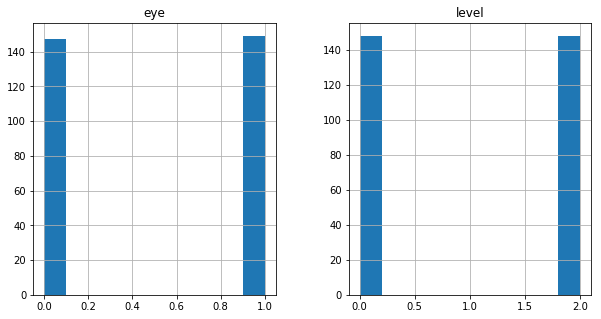

In [75]:
print('New Data Size:', train_df.shape[0], 'Old Size:', retina_df.shape[0])
train_df[['level', 'eye']].hist(figsize = (10, 5))

In [76]:
fnames = train_df['path'].as_matrix()
labels = train_df['level'].as_matrix()
labels[10:]

/home/bekkasik/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/home/bekkasik/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [77]:
test_label = train_df.level.unique()[-1]

PatientID                                                39648
level                                                        2
eye                                                          1
path         ../input/diabetic-retinopathy-detection/39648_...
Name: 148, dtype: object


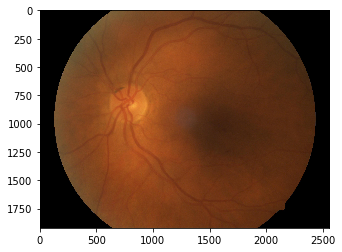

In [82]:
patient_example = train_df.loc[train_df['level'] == test_label].iloc[0]
patient_example_index = train_df.index[train_df['PatientID'] == patient_example['PatientID']][-1]
print(patient_example)
assert labels[patient_example_index] == test_label, f"Check that patient with id {patient_example_index}'s label is equal to {test_label}"

img = plt.imread(f'{fnames[patient_example_index]}')
plt.imshow(img);

In [83]:
img.shape

(1920, 2560, 3)

In [84]:
data = ImageClassifierData.from_names_and_array(
    path='./', 
    fnames=fnames, 
    y=labels, 
    classes=sorted(retina_df.level.unique()), 
    test_name=None, 
    tfms=tfms_from_model(arch, sz)
)

In [85]:
img_name = data.trn_ds.fnames[0]; img_name

'../input/diabetic-retinopathy-detection/33895_right.jpeg'

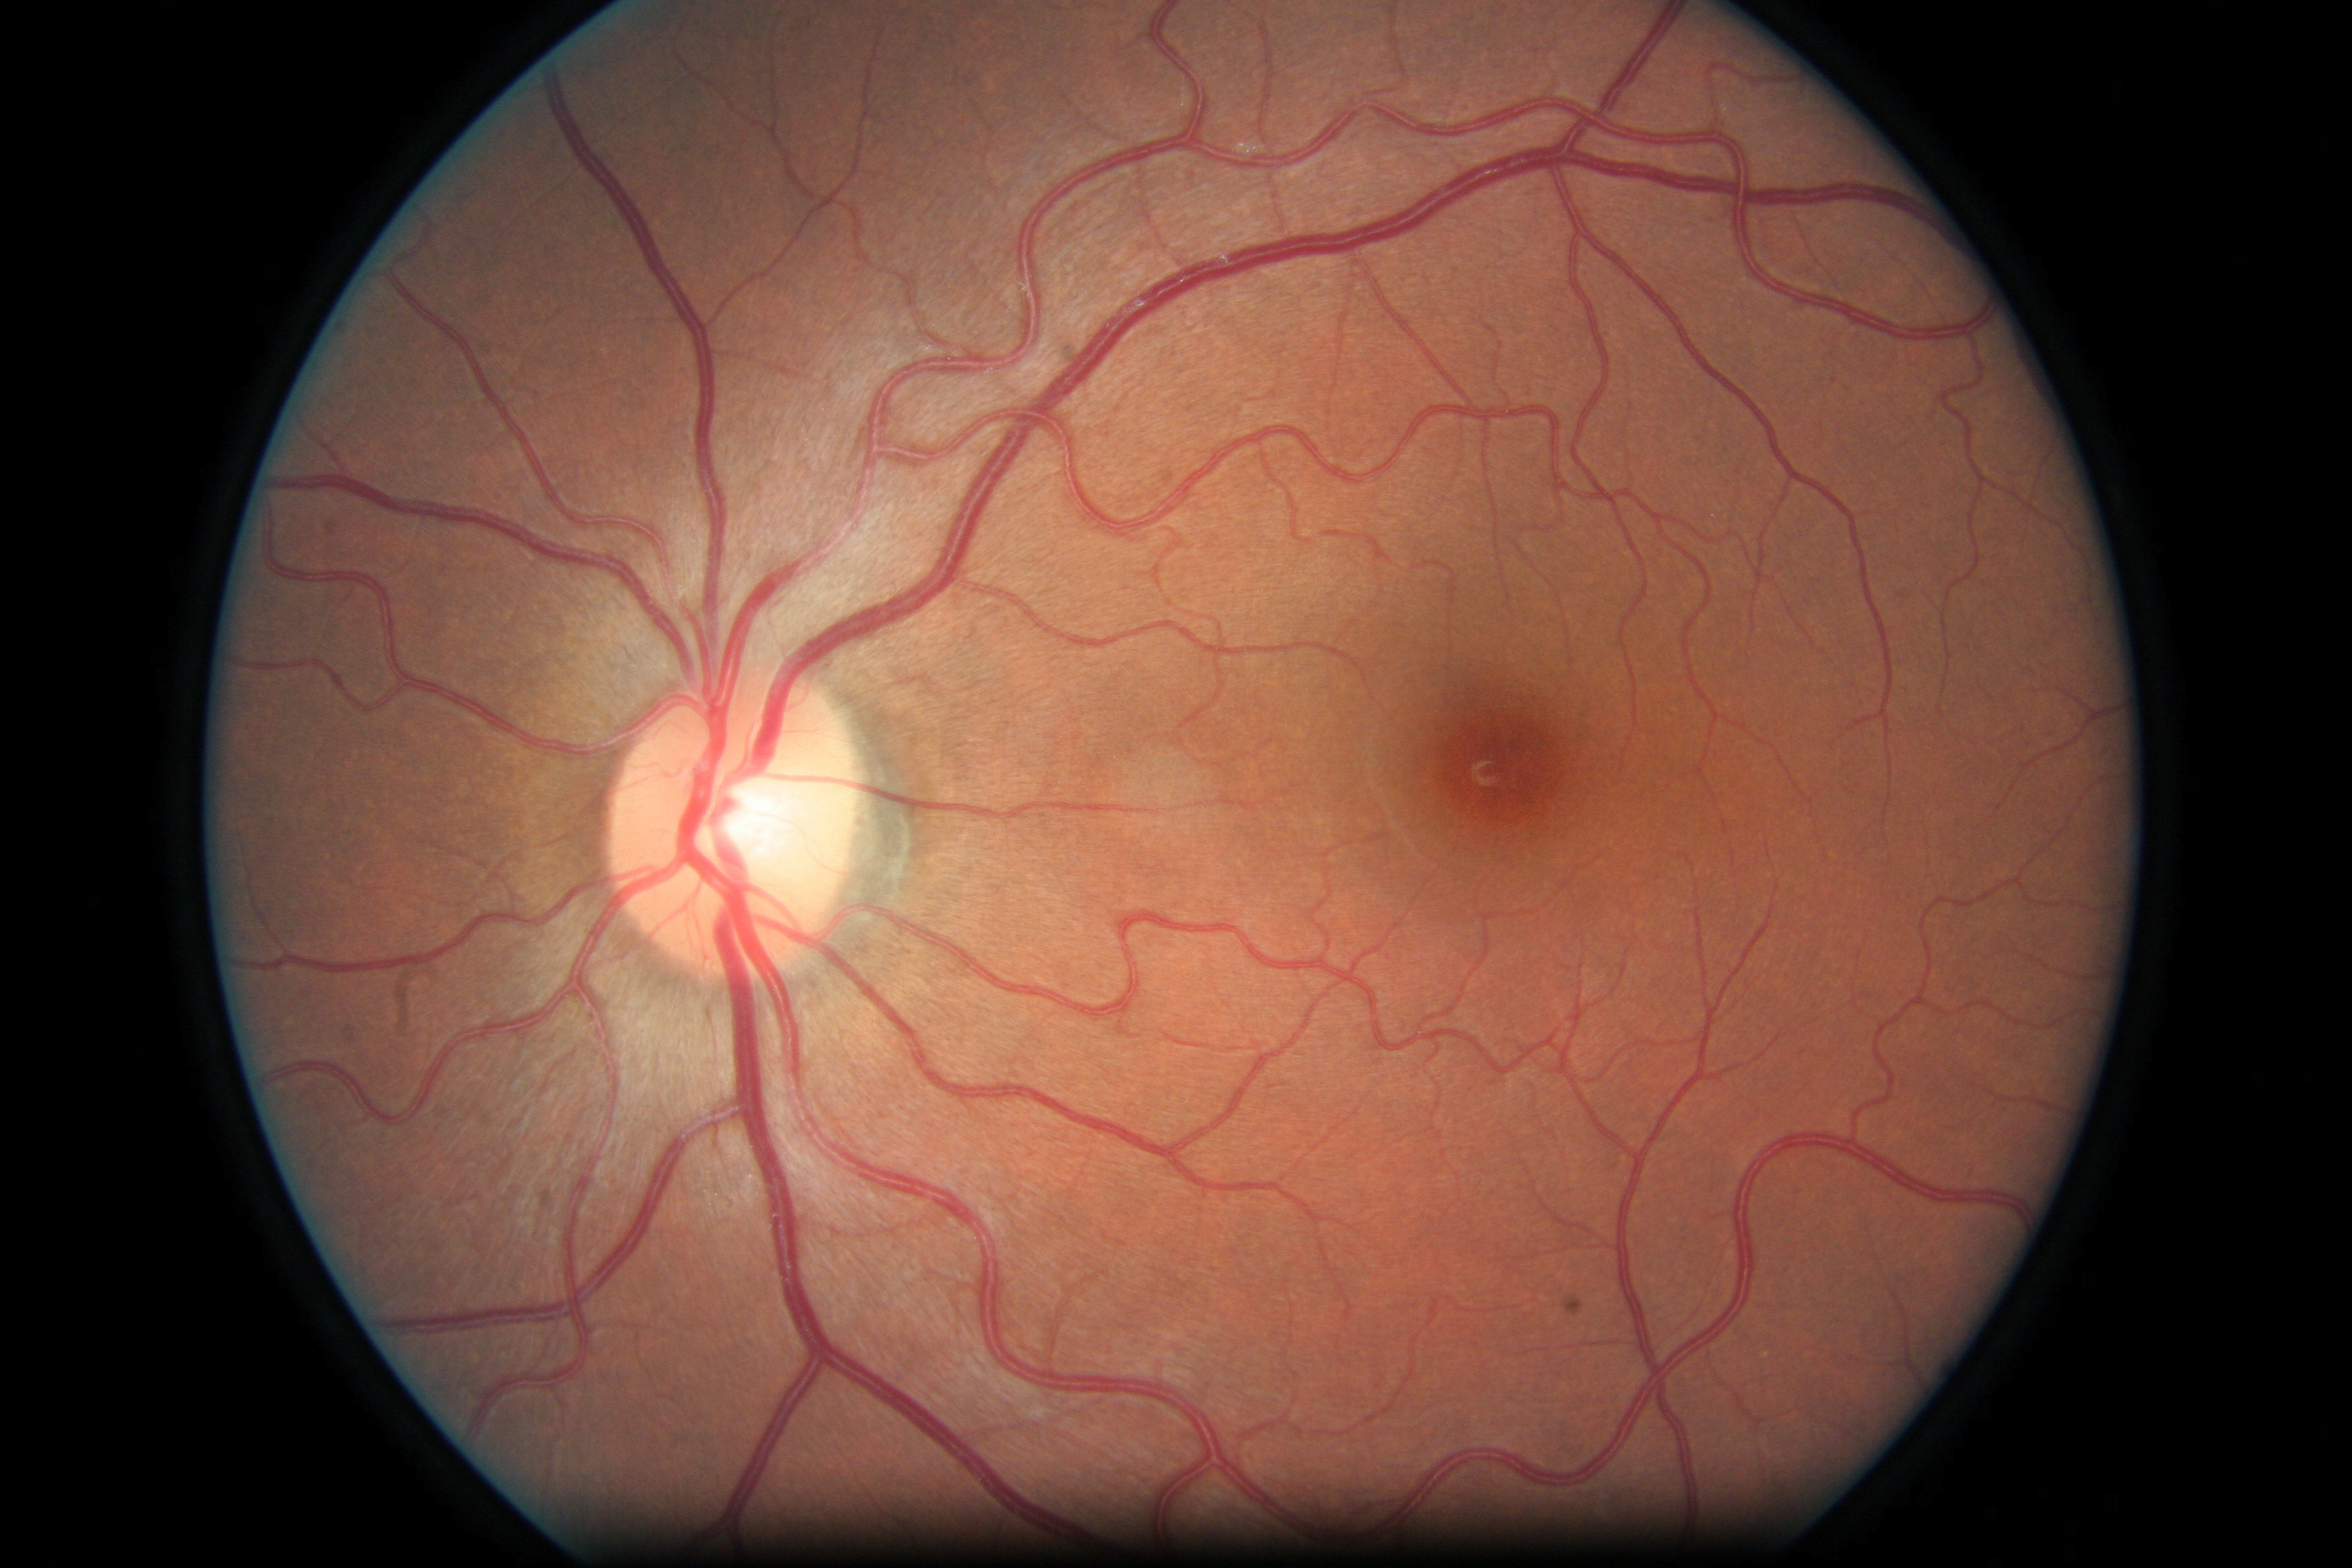

In [86]:
img = PIL.Image.open(img_name); img

In [87]:
img.size

(3504, 2336)

In [88]:
size_d = {k: PIL.Image.open(k).size for k in data.trn_ds.fnames}
row_sz, col_sz = list(zip(*size_d.values()))
row_sz = np.array(row_sz);
col_sz = np.array(col_sz)

(array([ 4.,  0., 49.,  8.,  9., 50., 68.,  3.,  0., 44.]),
 array([1792. , 2105.6, 2419.2, 2732.8, 3046.4, 3360. , 3673.6, 3987.2, 4300.8, 4614.4, 4928. ]),
 <a list of 10 Patch objects>)

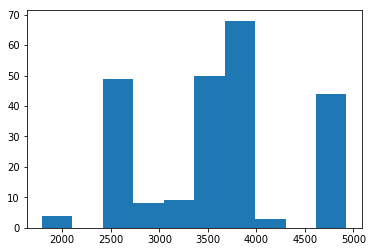

In [90]:
plt.hist(row_sz)

(array([ 4.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0., 51.]),
 array([1184., 1260., 1336., 1412., 1488., 1564., 1640., 1716., 1792., 1868., 1944.]),
 <a list of 10 Patch objects>)

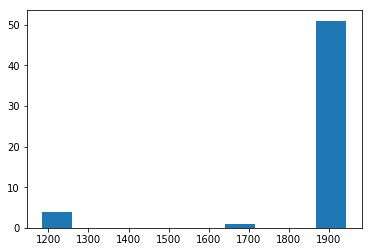

In [93]:
plt.hist(col_sz[col_sz < 2000])

In [96]:
def get_data(sz, bs=4): # sz: image size, bs: batch size
#     tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    tfms = tfms_from_model(arch, sz)
    data = ImageClassifierData.from_names_and_array(
        path='./', 
        fnames=fnames, 
        y=labels, 
        classes=sorted(retina_df.level.unique()), 
        test_name=None,
        tfms=tfms,
        bs=bs
    )
    
    if len(data.trn_ds) % bs == 1:
        data = ImageClassifierData.from_names_and_array(path='./', classes=sorted(retina_df.level.unique()), test_name=None, tfms=tfms, bs=bs,
            fnames=fnames[:-1], 
            y=labels[:-1]
        )
    assert len(data.trn_ds) % bs != 1, 'This condition makes sure that we never have a batch size of 1, which could cause issues with lr_find for instance.'
    return data

In [97]:
data = get_data(sz = sz, bs = 4)

In [102]:
print(f'Sample classes: {retina_df.level.unique()}')

learn = ConvLearner.pretrained(arch, data, precompute=True, tmp_name=TMP_PATH, models_name=MODEL_PATH)
learn.fit(1e-2, 3)

Sample classes: [0 2]


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/bekkasik/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [15:02<00:00, 96766.79it/s]  


  0%|          | 0/59 [00:00<?, ?it/s]

/home/bekkasik/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/home/bekkasik/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


100%|██████████| 15/15 [00:04<00:00,  3.08it/s]


epoch      trn_loss   val_loss   accuracy                  
    0      2.310852   1.681858   0.610169  
    1      2.251878   1.636859   0.576271                  
    2      2.237865   2.408955   0.610169                  



[2.4089552840944064, 0.610169492535672]

In [105]:
def get_80percent_accuracy_with_sample_bias():
    fnames2 = retina_df['path'].as_matrix()[:-1]
    labels2 = retina_df['level'].as_matrix()[:-1]

    data = ImageClassifierData.from_names_and_array(
        path='./',
        fnames=fnames2,
        y=labels2,
        classes=sorted(retina_df.level.unique()),
        test_name=None,
        tfms=tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    )

    print(retina_df.pivot_table(index='level', aggfunc=len).sort_values('PatientID', ascending=False))

    return ConvLearner.pretrained(arch, data, precompute=True, tmp_name=TMP_PATH, models_name=MODEL_PATH)

learn = get_80percent_accuracy_with_sample_bias()

/home/bekkasik/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/bekkasik/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


       PatientID    eye   path
level                         
0          25810  25810  25810
2           5292   5292   5292


/home/bekkasik/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1535491974311/work/aten/src/THC/generic/THCTensorMath.cu:15